In [1]:
# === User configuration cell ===

# Prompt user for minimum window size
while True:
    try:
        MIN_WINDOW_SIZE_MINUTES = int(input("Enter minimum window size in minutes (e.g., 30): "))
        if MIN_WINDOW_SIZE_MINUTES <= 0:
            print("❌ Please enter a positive number.")
        else:
            break
    except ValueError:
        print("❌ Invalid input. Please enter an integer.")

# Define possible ES modes
ES_MODES = ['ModeA', 'ModeB', 'ModeC']

# Show options and prompt user for ES mode
print("Available ES Modes:", ES_MODES)
while True:
    SELECTED_ES_MODE = input(f"Select ES Mode {ES_MODES}: ")
    if SELECTED_ES_MODE in ES_MODES:
        break
    else:
        print(f"❌ Invalid mode. Please choose one of: {ES_MODES}")

print(f"✅ Selected minimum window size: {MIN_WINDOW_SIZE_MINUTES} minutes")
print(f"✅ Selected ES Mode: {SELECTED_ES_MODE}")


Enter minimum window size in minutes (e.g., 30): 30
Available ES Modes: ['ModeA', 'ModeB', 'ModeC']
Select ES Mode ['ModeA', 'ModeB', 'ModeC']: ModeA
✅ Selected minimum window size: 30 minutes
✅ Selected ES Mode: ModeA


In [2]:
!pip install prophet pandas matplotlib


In [3]:
from google.colab import files
uploaded = files.upload()  # upload ES_PM_Data.zip interactively

import zipfile
import os

zip_path = next(iter(uploaded))  # get uploaded filename
extract_to = '/content/ES_PM_Data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipped files:")
print(os.listdir(extract_to))


Saving ES_PM_Data.zip to ES_PM_Data.zip
Unzipped files:
['ES_PM_Data']


In [4]:
import os

# Root extraction path
extract_to = '/content/ES_PM_Data'

# List what's inside root
contents = os.listdir(extract_to)
print("Top-level contents after unzip:", contents)

# If there is only one item and it's a folder, use it as actual data folder
if len(contents) == 1 and os.path.isdir(os.path.join(extract_to, contents[0])):
    data_folder = os.path.join(extract_to, contents[0])
else:
    data_folder = extract_to  # no nested folder, data is in root

print(f"Using data folder: {data_folder}")

# Now list files inside the real data folder:
print("Files in data folder:", os.listdir(data_folder))


Top-level contents after unzip: ['ES_PM_Data']
Using data folder: /content/ES_PM_Data/ES_PM_Data
Files in data folder: ['DL_Prb_Utilization_Data.csv', 'Avg_UE_Number_Data.csv']


In [5]:
import os
print("Files extracted:")
print(os.listdir(extract_to))


Files extracted:
['ES_PM_Data']


In [6]:
files_in_folder = os.listdir(data_folder)
print("Files in selected data folder:", files_in_folder)

dl_files = [f for f in files_in_folder if 'dl' in f.lower()]
ue_files = [f for f in files_in_folder if 'avg' in f.lower()]

if not dl_files or not ue_files:
    raise FileNotFoundError("Could not find required CSV files. Make sure they exist and contain 'DL' and 'Avg' in filenames.")

dl_prb_csv = dl_files[0]
avg_ue_csv = ue_files[0]

print(f"Using DL file: {dl_prb_csv}")
print(f"Using Avg UE file: {avg_ue_csv}")


Files in selected data folder: ['DL_Prb_Utilization_Data.csv', 'Avg_UE_Number_Data.csv']
Using DL file: DL_Prb_Utilization_Data.csv
Using Avg UE file: Avg_UE_Number_Data.csv


In [7]:
import pandas as pd
import os

# Read the identified CSVs using the correct folder
dl_df = pd.read_csv(os.path.join(data_folder, dl_prb_csv))
ue_df = pd.read_csv(os.path.join(data_folder, avg_ue_csv))

# Show their columns so you know exactly what they contain
print("DL_Prb_Utilization columns:", dl_df.columns)
print("Avg_UE_Number columns:", ue_df.columns)

dl_df['Timestamp'] = pd.to_datetime(dl_df['Timestamp'], format='mixed', errors='coerce')
ue_df['Timestamp'] = pd.to_datetime(ue_df['Timestamp'], format='mixed', errors='coerce')


# Preview first few rows of each dataframe
print("\nDL_Prb_Utilization sample:")
print(dl_df.head())

print("\nAvg_UE_Number sample:")
print(ue_df.head())


DL_Prb_Utilization columns: Index(['Timestamp', 'NCI', 'gNB', 'DL_Prb_Utilization'], dtype='object')
Avg_UE_Number columns: Index(['Timestamp', 'NCI', 'gNB', 'Avg_UE_Number'], dtype='object')

DL_Prb_Utilization sample:
   Timestamp        NCI      gNB  DL_Prb_Utilization
0 2024-02-01  357783981  1397593                  24
1 2024-02-01  357783979  1397593                  24
2 2024-02-01  357783980  1397593                  13
3 2024-02-01  358531244  1400512                  29
4 2024-02-01  358531245  1400512                  21

Avg_UE_Number sample:
   Timestamp        NCI      gNB  Avg_UE_Number
0 2024-02-01  357783981  1397593             10
1 2024-02-01  357783979  1397593              3
2 2024-02-01  357783980  1397593              8
3 2024-02-01  358531244  1400512              7
4 2024-02-01  358531245  1400512              8


In [8]:
# List unique cells in both dataframes
print("DL_Prb_Utilization cell IDs:", dl_df['NCI'].unique())
print("Avg_UE_Number cell IDs:", ue_df['NCI'].unique())

# Pick a cell that is present in both; replace with your desired cell if needed
cell_id = dl_df['NCI'].unique()[0]
print(f"Using cell ID: {cell_id}")


DL_Prb_Utilization cell IDs: [357783981 357783979 357783980 358531244 358531245 358531243]
Avg_UE_Number cell IDs: [357783981 357783979 357783980 358531244 358531245 358531243]
Using cell ID: 357783981


In [9]:
# Filter rows for the chosen cell
dl_cell = dl_df[dl_df['NCI'] == cell_id].copy()
ue_cell = ue_df[ue_df['NCI'] == cell_id].copy()

print(f"DL_Prb_Utilization rows for {cell_id}: {len(dl_cell)}")
print(f"Avg_UE_Number rows for {cell_id}: {len(ue_cell)}")


DL_Prb_Utilization rows for 357783981: 43776
Avg_UE_Number rows for 357783981: 43776


In [10]:
# Merge on common timestamps
merged = pd.merge(
    dl_cell[['Timestamp', 'DL_Prb_Utilization']],
    ue_cell[['Timestamp', 'Avg_UE_Number']],
    on='Timestamp'
)

print(f"Merged overlapping rows for {cell_id}: {len(merged)}")
print(merged.head())


Merged overlapping rows for 357783981: 43776
            Timestamp  DL_Prb_Utilization  Avg_UE_Number
0 2024-02-01 00:00:00                  24             10
1 2024-02-01 00:15:00                  25              3
2 2024-02-01 00:30:00                  24              5
3 2024-02-01 00:45:00                  28              1
4 2024-02-01 01:00:00                  15              5


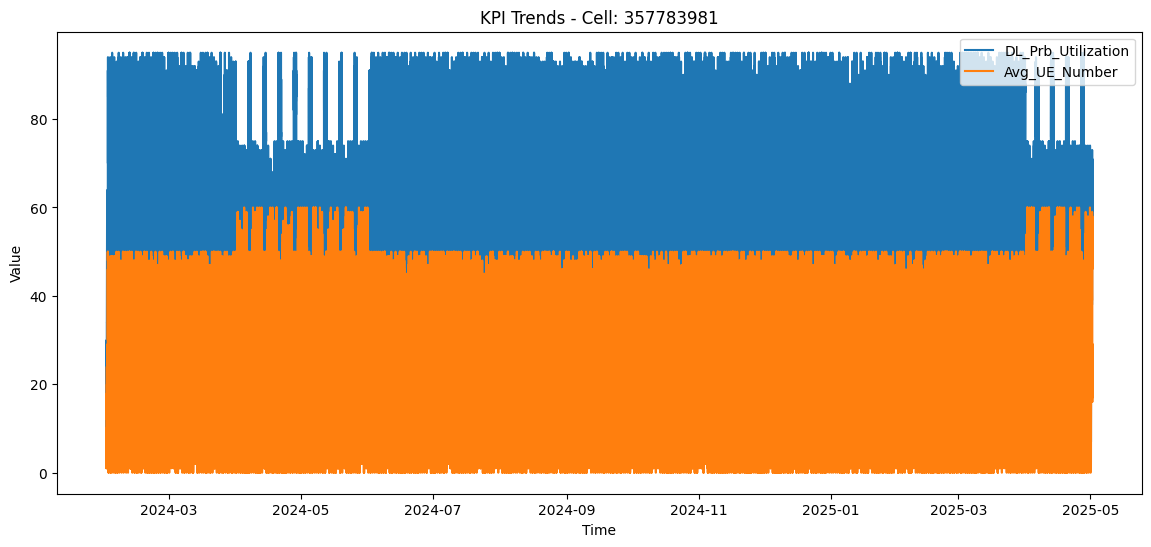

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(merged['Timestamp'], merged['DL_Prb_Utilization'], label='DL_Prb_Utilization')
plt.plot(merged['Timestamp'], merged['Avg_UE_Number'], label='Avg_UE_Number')
plt.title(f"KPI Trends - Cell: {cell_id}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


In [12]:
from prophet import Prophet

# Prepare Prophet input dataframe
prophet_df = merged[['Timestamp', 'DL_Prb_Utilization']].rename(columns={
    'Timestamp': 'ds',
    'DL_Prb_Utilization': 'y'
})

print("Prophet dataframe sample:")
print(prophet_df.head())


Prophet dataframe sample:
                   ds   y
0 2024-02-01 00:00:00  24
1 2024-02-01 00:15:00  25
2 2024-02-01 00:30:00  24
3 2024-02-01 00:45:00  28
4 2024-02-01 01:00:00  15


In [13]:
# Create Prophet model
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # enable if your data has yearly trends
    changepoint_prior_scale=0.5  # tuning parameter
)

# Fit model on data
model.fit(prophet_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_03g9em8/dy7vjvo8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_03g9em8/ys3nusnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35259', 'data', 'file=/tmp/tmp_03g9em8/dy7vjvo8.json', 'init=/tmp/tmp_03g9em8/ys3nusnw.json', 'output', 'file=/tmp/tmp_03g9em8/prophet_model5tmun9g4/prophet_model-20250707163119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:31:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:31:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [14]:
# Calculate interval in minutes
interval_minutes = (prophet_df['ds'].iloc[1] - prophet_df['ds'].iloc[0]).total_seconds() / 60
print(f"Sampling interval: {interval_minutes:.1f} minutes")

# Calculate steps for next 6 months (approx. 6*30 days)
steps = int((6 * 30 * 24 * 60) / interval_minutes)

# Create future dataframe
future = model.make_future_dataframe(periods=steps, freq=f'{int(interval_minutes)}min')

print(f"Future dataframe will forecast {len(future) - len(prophet_df)} additional points.")


Sampling interval: 15.0 minutes
Future dataframe will forecast 17280 additional points.


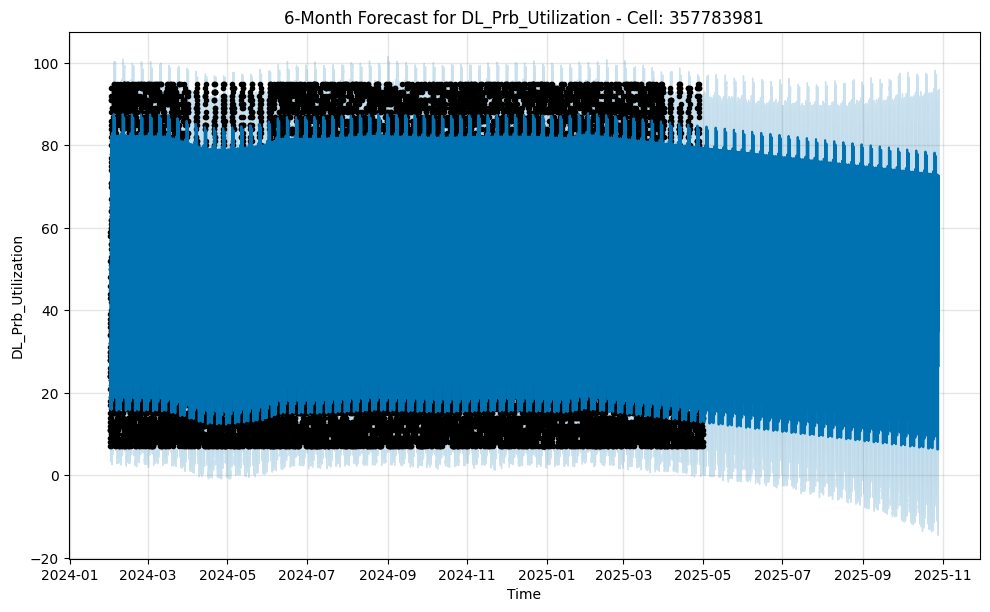

In [15]:
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title(f"6-Month Forecast for DL_Prb_Utilization - Cell: {cell_id}")
plt.xlabel("Time")
plt.ylabel("DL_Prb_Utilization")
plt.show()


In [16]:
output_path = f'/content/forecast_{cell_id}_DL_Prb.csv'
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(output_path, index=False)
print(f"Forecast saved to: {output_path}")

# Optional: download from Colab
from google.colab import files
files.download(output_path)


Forecast saved to: /content/forecast_357783981_DL_Prb.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import pandas as pd

df = pd.read_csv('/content/forecast_357783981_DL_Prb.csv')
print(df.columns)


Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')


In [18]:
df['predicted_dl_prb'] = df['yhat']

In [24]:
print("✅ Avg_UE timestamp column types:")
print(avg_ue_df['Timestamp'].head())
print(avg_ue_df['Timestamp'].dtypes)

print("\n✅ DL_PRB timestamp column types:")
print(dl_prb_df['Timestamp'].head())
print(dl_prb_df['Timestamp'].dtypes)


✅ Avg_UE timestamp column types:
0    02-01-2024 00:00
1    02-01-2024 00:00
2    02-01-2024 00:00
3    02-01-2024 00:00
4    02-01-2024 00:00
Name: Timestamp, dtype: object
object

✅ DL_PRB timestamp column types:
0    02-01-2024 00:00
1    02-01-2024 00:00
2    02-01-2024 00:00
3    02-01-2024 00:00
4    02-01-2024 00:00
Name: Timestamp, dtype: object
object


In [26]:
import pandas as pd

# === User Inputs ===
MIN_WINDOW_SIZE_MINUTES = int(input("Enter minimum window size in minutes (e.g., 30): "))
ES_MODES = ['ModeA', 'ModeB', 'ModeC']
print("Available ES Modes:", ES_MODES)

while True:
    SELECTED_ES_MODE = input(f"Select ES Mode {ES_MODES}: ")
    if SELECTED_ES_MODE in ES_MODES:
        break
    else:
        print(f"❌ Invalid mode. Choose from: {ES_MODES}")

print(f"✅ Selected minimum window size: {MIN_WINDOW_SIZE_MINUTES} minutes")
print(f"✅ Selected ES Mode: {SELECTED_ES_MODE}")

# === Load KPI Data ===
avg_ue_df = pd.read_csv('/content/ES_PM_Data/ES_PM_Data/Avg_UE_Number_Data.csv')
dl_prb_df = pd.read_csv('/content/ES_PM_Data/ES_PM_Data/DL_Prb_Utilization_Data.csv')

# === Parse Timestamps Correctly (dayfirst format) ===
avg_ue_df['Timestamp'] = pd.to_datetime(avg_ue_df['Timestamp'], dayfirst=True, errors='coerce')
dl_prb_df['Timestamp'] = pd.to_datetime(dl_prb_df['Timestamp'], dayfirst=True, errors='coerce')

# === Check for NaT ===
print("❗ Invalid Avg_UE timestamps:", avg_ue_df['Timestamp'].isna().sum())
print("❗ Invalid DL_PRB timestamps:", dl_prb_df['Timestamp'].isna().sum())

# === Determine Overlap ===
start_avg, end_avg = avg_ue_df['Timestamp'].min(), avg_ue_df['Timestamp'].max()
start_dl, end_dl = dl_prb_df['Timestamp'].min(), dl_prb_df['Timestamp'].max()

overlap_start = max(start_avg, start_dl)
overlap_end = min(end_avg, end_dl)
overlap_duration = (overlap_end - overlap_start).total_seconds() / 60

if overlap_duration >= MIN_WINDOW_SIZE_MINUTES:
    # Filter for overlapping window
    avg_ue_overlap = avg_ue_df[(avg_ue_df['Timestamp'] >= overlap_start) & (avg_ue_df['Timestamp'] <= overlap_end)]
    dl_prb_overlap = dl_prb_df[(dl_prb_df['Timestamp'] >= overlap_start) & (dl_prb_df['Timestamp'] <= overlap_end)]

    # Merge both on timestamp
    merged_df = pd.merge(avg_ue_overlap, dl_prb_overlap, on='Timestamp', suffixes=('_avg_ue', '_dl_prb'))

    # Add selected ES mode
    merged_df['selected_es_mode'] = SELECTED_ES_MODE

    # Save overlapping window output
    merged_df.to_csv('overlapping_window_output.csv', index=False)
    print("✅ overlapping_window_output.csv created successfully!")
    print(f"Overlapping window duration: {overlap_duration:.2f} minutes from {overlap_start} to {overlap_end}")

    # === Recommended Cells Logic ===
    merged_df['cell_id'] = 'Unknown_Cell'  # You can replace this if you have real cell info

    recommendations = []
    if 'yhat_dl_prb' in merged_df.columns and 'yhat_avg_ue' in merged_df.columns:
        for cell in merged_df['cell_id'].unique():
            cell_df = merged_df[merged_df['cell_id'] == cell]

            if cell_df['yhat_dl_prb'].max() > 90:
                recommendations.append({'cell_id': cell, 'reason': 'DL PRB > 90% (congestion)'})

            if cell_df['yhat_avg_ue'].max() > 100:
                recommendations.append({'cell_id': cell, 'reason': 'Avg UE > 100 (high load)'})
    else:
        print("⚠️ yhat_dl_prb or yhat_avg_ue columns not found! Check your forecast file structure.")

    # Save recommended cells
    rec_df = pd.DataFrame(recommendations).drop_duplicates()
    rec_df.to_csv('recommended_cells.csv', index=False)

    if rec_df.empty:
        print("✅ recommended_cells.csv created but empty (no high-risk cells).")
    else:
        print("✅ recommended_cells.csv created with high-risk cells.")
else:
    print(f"❌ No common window ≥ {MIN_WINDOW_SIZE_MINUTES} mins. Found only {overlap_duration:.2f} mins.")


Enter minimum window size in minutes (e.g., 30): 30
Available ES Modes: ['ModeA', 'ModeB', 'ModeC']
Select ES Mode ['ModeA', 'ModeB', 'ModeC']: ModeA
✅ Selected minimum window size: 30 minutes
✅ Selected ES Mode: ModeA
❗ Invalid Avg_UE timestamps: 158400
❗ Invalid DL_PRB timestamps: 158400
✅ overlapping_window_output.csv created successfully!
Overlapping window duration: 1012305.00 minutes from 2024-01-02 00:00:00 to 2025-12-04 23:45:00
⚠️ yhat_dl_prb or yhat_avg_ue columns not found! Check your forecast file structure.
✅ recommended_cells.csv created but empty (no high-risk cells).
